# Симуляция распространения болезни по авиарейсам

Импорт необходимых библиотек.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 12]

import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms import community

Загрузка датасета аэропортов.

In [3]:
airports = pd.read_csv('US_airport_id_info-1801-b70d72.csv')
airports

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325
...,...,...,...,...,...,...,...,...
274,274,RDD,Redding Muni,Redding,40.509000,-122.293389,-1.976890e+06,334403.078441
275,275,SUN,Friedman Mem,Hailey,43.504444,-114.296194,-1.261565e+06,515731.793677
276,276,TWF,Magic Valley Regional Airport,Twin Falls,42.481803,-114.487733,-1.296508e+06,406881.420680
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander,45.631200,-89.467500,7.102613e+05,678171.825235


Загрузка датасета рейсов.

In [4]:
flights = pd.read_csv('events_US_air_traffic_GMT-1801-4d20a3.txt', sep=' ')
flights

,Source,Destination,StartTime,EndTime,Duration
0,0,1,1229286900,1.229292e+09,4620.0
1,0,1,1229272800,1.229277e+09,4500.0
2,0,2,1229285640,1.229292e+09,5880.0
3,0,3,1229268060,1.229276e+09,7980.0
4,0,3,1229284740,1.229293e+09,8400.0
...,...,...,...,...,...
61367,31,142,1229538300,1.229543e+09,5100.0
61368,31,16,1229528100,1.229541e+09,13080.0
61369,31,24,1229528100,1.229539e+09,10560.0
61370,31,23,1229518200,1.229535e+09,16740.0


Подсчитаем пропуски и удалим рейсы с ними.

In [5]:
flights.isna().sum().sum()

2

In [6]:
flights.dropna(inplace = True)
flights.isna().sum().sum()

0

Создадим колонку для времени заражения аэропорта.

In [7]:
airports['infection time'] = 0
airports

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz,infection time
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978,0
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074,0
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565,0
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396,0
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325,0
...,...,...,...,...,...,...,...,...,...
274,274,RDD,Redding Muni,Redding,40.509000,-122.293389,-1.976890e+06,334403.078441,0
275,275,SUN,Friedman Mem,Hailey,43.504444,-114.296194,-1.261565e+06,515731.793677,0
276,276,TWF,Magic Valley Regional Airport,Twin Falls,42.481803,-114.487733,-1.296508e+06,406881.420680,0
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander,45.631200,-89.467500,7.102613e+05,678171.825235,0


Отсортируем датасет рейсов по времени вылета.

In [8]:
flights.sort_values('StartTime', inplace=True)
flights

,Source,Destination,StartTime,EndTime,Duration
16150,27,49,1229231100,1.229247e+09,15660.0
16997,30,2,1229233200,1.229246e+09,12780.0
14055,251,20,1229235000,1.229246e+09,11340.0
4463,12,4,1229235300,1.229245e+09,9660.0
2160,180,20,1229235300,1.229246e+09,10200.0
...,...,...,...,...,...
60367,55,12,1229584500,1.229609e+09,24660.0
60474,55,16,1229584800,1.229605e+09,19800.0
60378,55,16,1229584800,1.229604e+09,19200.0
60471,55,23,1229586600,1.229606e+09,19740.0


## Симуляция

In [9]:
# Функция симуляции принимает на вход id начального города и вероятность заражения
def simulate_infection(start_city = 0, P = 0.5):
    
    # Работаем с копией датасета аэропортов
    ap = airports.copy()
    
    # Ставим время заражения начального города в минимальное значение времени из датасета рейсов
    ap.loc[start_city,'infection time'] = flights['StartTime'].min()
    
    for flight in flights.itertuples():
        
        # Если город вылета ещё не заражён, следующий шаг цикла
        if ap.loc[getattr(flight,'Source'),'infection time'] == 0: continue
            
        # Если город прибытия уже заражён, следующий шаг цикла
        if ap.loc[getattr(flight,'Destination'),'infection time'] > 0: continue
            
        # Если время вылета меньше, чем время заражения города вылета, следующий шаг цикла
        if getattr(flight,'StartTime') < ap.loc[getattr(flight,'Source'),'infection time']: continue
            
        # Если случайное число больше порога, следующий шаг цикла
        if np.random.random() > P: continue
            
        # Ставим городу прибытия время заражения как время прибытия рейса
        ap.loc[getattr(flight,'Destination'),'infection time'] = getattr(flight,'EndTime')
           
    # Возвращаем словарь: ключ — id аэропорта, значение — время заражения. Выбираем только те аэропорты, которые заразились
    return dict(ap[ap['infection time'] > 0][['id','infection time']].values)

## Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

Прогоним по 10 симуляций для разных вероятностей, сохранив результаты.

In [10]:
from tqdm import tqdm

res = {}
probs = [0.01, 0.05, 0.1, 0.5, 1]
for p in probs:
    res[p] = []
    for i in tqdm(range(10)):
        res[p].append(simulate_infection(0,p))

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Пройдёмся в цикле от времени начала первого рейса до времени окончания последнего с шагом в 12 часов.

Посчитаем долю заражённых аэропортов на каждом отрезке времени для разных вероятностей, сохраним вычисления в словаре contamination.

In [11]:
infection_start_time = int(flights['StartTime'].min())
infection_end_time = int(flights['EndTime'].max())
airports_total = airports.shape[0]

contamination = {}
for p in res:
    contamination[p] = {}
    
for t in tqdm(range(infection_start_time, infection_end_time, 12*60*60)):
    for p in res:
        s = 0
        for d in res[p]:
            s += len([x for x in d.values() if x <= t])
        h = int((t - infection_start_time) / 60 / 60)
        contamination[p][h] = s / len(res[p]) / airports_total

100%|██████████| 9/9 [00:00<00:00, 192.01it/s]


In [12]:
contamination

{0.01: {0: 0.0035842293906810036,
  12: 0.003942652329749104,
  24: 0.006093189964157706,
  36: 0.007168458781362007,
  48: 0.02043010752688172,
  60: 0.03655913978494624,
  72: 0.07025089605734768,
  84: 0.08100358422939069,
  96: 0.10215053763440861},
 0.05: {0: 0.0035842293906810036,
  12: 0.025806451612903226,
  24: 0.2025089605734767,
  36: 0.2885304659498208,
  48: 0.4017921146953405,
  60: 0.43476702508960574,
  72: 0.5455197132616487,
  84: 0.574910394265233,
  96: 0.6225806451612903},
 0.1: {0: 0.0035842293906810036,
  12: 0.027240143369175625,
  24: 0.23584229390681002,
  36: 0.3265232974910394,
  48: 0.5311827956989247,
  60: 0.5666666666666667,
  72: 0.6652329749103942,
  84: 0.6899641577060932,
  96: 0.7530465949820788},
 0.5: {0: 0.0035842293906810036,
  12: 0.3129032258064516,
  24: 0.8734767025089605,
  36: 0.9150537634408602,
  48: 0.9688172043010753,
  60: 0.974910394265233,
  72: 0.9853046594982078,
  84: 0.9860215053763441,
  96: 0.9888888888888888},
 1: {0: 0.00358

Построим графики распространения инфекции для разных вероятностей.

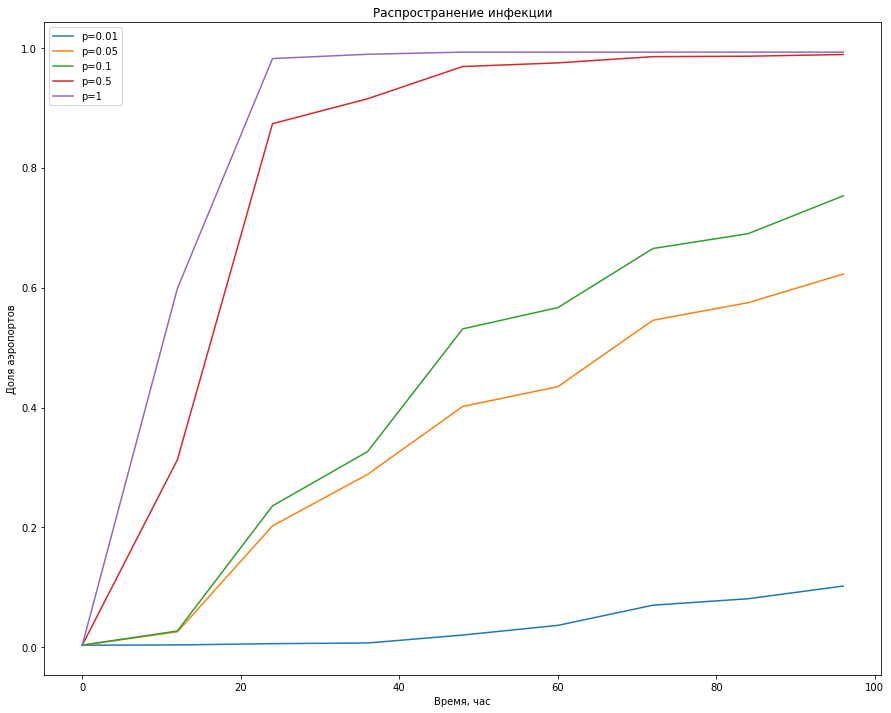

In [13]:
plt.title('Распространение инфекции')
plt.xlabel("Время, час")
plt.ylabel("Доля аэропортов")
for p in contamination:
    plt.plot(*zip(*sorted(contamination[p].items())), label=f"p={p}")
plt.legend()

Графики соответствуют ожиданиям: при вероятности заражения 1% доля инфицированных аэропортов не превысит 10%, при вероятности заражения 100% почти все аэропорты инфицируются уже за 20 часов.

## Может ли информация о сети помочь предсказать, кто будет заражен?

Построим граф, пробежав по датасету рейсов. Каждый рейс между двумя аэропортами увеличивает вес ребра между ними.

In [16]:
G = nx.Graph()
for flight in flights.itertuples():
    if G.has_edge(flight.Source, flight.Destination):
        G[flight.Source][flight.Destination]['weight'] += 1
    else:
        G.add_edge(flight.Source, flight.Destination, weight=1)
        
G.number_of_nodes(), G.number_of_edges()

(278, 2017)

Преобразуем веса в доли, разделив на общее количество рейсов.

In [17]:
total_flights = flights.shape[0]
for e in G.edges.data("weight", default=1):
    G[e[0]][e[1]]['weight'] = e[2] / total_flights

Если всё правильно, сумма весов графа должна быть равна 1.

In [18]:
G.size(weight='weight')

0.9999999999999998

Прогоним симуляцию 50 раз, сохранив результаты.

In [19]:
res = []
for i in tqdm(range(50)):
    res.append(simulate_infection())

100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


Создадим датафрейм airports_analysis_data. Сначала запишем в него медианное время заражения.

In [20]:
airports_analysis_data = {}

# Для всех словарей из результатов
for d in res:
    # Бежим по словарю
    for k, v in d.items():
        # Формируем для каждого id список из значений времени заражения
        if k not in airports_analysis_data:
            airports_analysis_data[k] = []
        airports_analysis_data[k].append(v)

for id in airports_analysis_data:
    # Если у какого-то аэропорта меньше 50 значений времени заражения,
    # дополняем список самым высоким значением времени (иначе медианы для таких аэропортов будут посчитаны некорректно)
    airports_analysis_data[id] += [infection_end_time + 1] * (50 - len(airports_analysis_data[id]))
    # Заменяем для каждого аэропорта список на медианное значение времени от начала распространения инфекции
    airports_analysis_data[id] = np.median(airports_analysis_data[id]) - infection_start_time

airports_analysis_data = pd.DataFrame(airports_analysis_data.items(), columns=['id','median time'])
airports_analysis_data.sort_values('id', inplace=True)
airports_analysis_data

,id,median time
0,0,0.0
1,1,35700.0
2,2,30960.0
3,3,35760.0
4,4,29340.0
...,...,...
271,273,79080.0
272,274,79440.0
273,275,66240.0
274,276,79800.0


Рассчитаем для всех узлов графа параметры Degree centrality, Betweenness centrality и Clustering (коэффициент кластеризации), запишем в датасет.

In [22]:
degree_centrality = nx.degree_centrality(G)
airports_analysis_data['degree centrality'] = pd.Series(degree_centrality)

betweenness_centrality = nx.betweenness_centrality(G)
airports_analysis_data['betweenness centrality'] = pd.Series(betweenness_centrality)

clustering = nx.clustering(G)
airports_analysis_data['clustering'] = pd.Series(clustering)

airports_analysis_data

,id,median time,degree centrality,betweenness centrality,clustering
0,0,0.0,0.018051,0.000000,1.000000
1,1,35700.0,0.202166,0.004468,0.531818
2,2,30960.0,0.231047,0.011347,0.439980
3,3,35760.0,0.451264,0.114374,0.182710
4,4,29340.0,0.530686,0.213784,0.137639
...,...,...,...,...,...
271,273,79080.0,0.007220,0.000000,1.000000
272,274,79440.0,0.010830,0.000000,1.000000
273,275,66240.0,0.003610,0.000000,0.000000
274,276,79800.0,0.003610,0.000000,0.000000


Построим графики распределения этих параметров от медианного времени заражения.

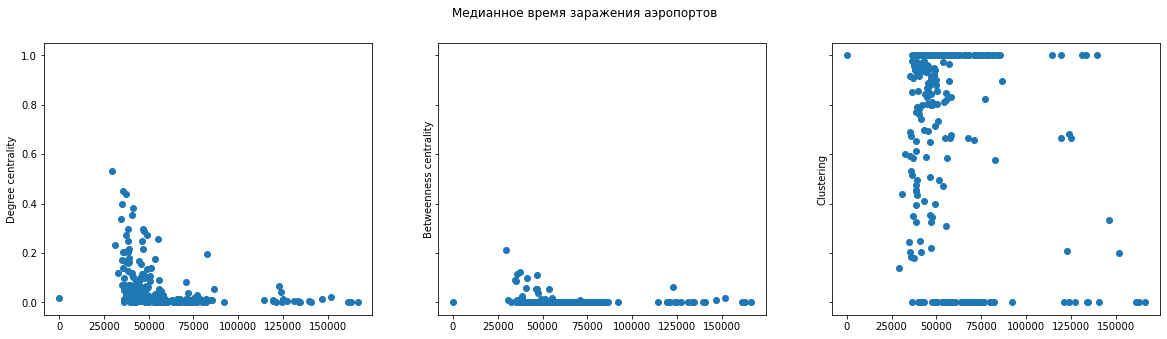

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(20, 5)
fig.suptitle('Медианное время заражения аэропортов')
ax1.set_ylabel('Degree centrality')
ax1.scatter(airports_analysis_data['median time'],airports_analysis_data['degree centrality'])
ax2.set_ylabel('Betweenness centrality')
ax2.scatter(airports_analysis_data['median time'],airports_analysis_data['betweenness centrality'])
ax3.set_ylabel('Clustering')
ax3.scatter(airports_analysis_data['median time'],airports_analysis_data['clustering'])

На левом графике можно увидеть определённую обратную зависимость, хотя значения центральности для многих узлов близки к 0.

На центральном графике зависимость почти не выражена из-за того, что значения степени посредничества для большинства аэропортов близки к 0. То есть кратчайшие пути проходят через небольшое количество основных аэропортов.

На правом графике наблюдается довольно хаотичное распределение.

Построим матрицу корреляций Спирмена.

In [24]:
airports_analysis_data.corr('spearman')

,id,median time,degree centrality,betweenness centrality,clustering
id,1.000000,0.609348,-0.661712,-0.642204,0.091032
median time,0.609348,1.000000,-0.579652,-0.433733,-0.060250
degree centrality,-0.661712,-0.579652,1.000000,0.848137,0.186619
betweenness centrality,-0.642204,-0.433733,0.848137,1.000000,-0.254992
clustering,0.091032,-0.060250,0.186619,-0.254992,1.000000


Как и предполагалось, наиболее сильная корреляция к медианному времени заражения существует у обычной центральности (Degree centrality). Чем больше соседей у аэропорта, тем быстрее он будет заражён.